# Applying the Model

In [1]:
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
#img_md_subset = pd.read_csv('../../../Data/all_images_231020.csv')

Now we're running the model on new data that hasn't had all the easy classes pulled from it

In [ ]:
import glob, os

tsv_list = []
for file in glob.glob("../../../Data/fresh_data_012121/preserved/all_imagery/*.tsv", recursive=True):
    tsv_list.append(file)
    
print(len(tsv_list))

In [ ]:
img_md_subset = pd.read_csv(tsv_list[0], sep='\t').iloc[1:][['object_id', 'sample_flag', 'object_lat', 'object_lon', 'object_date', 'object_time', 'object_peak_fluorescence', 'object_peak_scattering', 'object_equiv_diameter']]

for tsv in tsv_list[1:]:
    df_to_add = pd.read_csv(tsv, sep='\t').iloc[1:][['object_id', 'sample_flag', 'object_lat', 'object_lon', 'object_date', 'object_time', 'object_peak_fluorescence', 'object_peak_scattering', 'object_equiv_diameter']]
    img_md_subset = img_md_subset.append(df_to_add, ignore_index=True)

In [ ]:
len(img_md_subset)

In [ ]:
img_md_subset.columns

In [4]:
#img_md_subset.to_csv('../../../Data/fresh_data_012121/preserved/ifcb_ecotaxa_subset_012421.csv')
img_md_subset = pd.read_csv('../../../Data/fresh_data_012121/preserved/ifcb_ecotaxa_subset_012421.csv')

In [5]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']

In [6]:
import glob, os

file_dir = '../../../Data/fresh_data_012121/preserved/all_imagery/'

os.chdir(file_dir)

In [7]:
fn_list = []

for file in glob.glob("*.png"):
    fn_list.append(file)
    
print(len(fn_list))

fn_edit = [x[:-4] for x in fn_list]

available_subset = img_md_subset[img_md_subset['object_id'].isin(fn_edit)]
len(available_subset)

1630853


1630853

In [8]:
import sys
 
sys.getsizeof(fn_edit) / 1e9

0.01393188

In [9]:
del fn_edit

In [10]:
del img_md_subset

In [11]:
class_id_dict = {'Amphiprora': 0,
 'Banquisia belgicae': 1,
 'Chaetoceros single': 2,
 'Chaetoceros<Mediophyceae': 3,
 'Ciliophora': 4,
 'Corethron': 5,
 'Cryptophyta': 6,
 'Cylindrotheca': 7,
 'Dactyliosolen': 8,
 'Dictyochales': 9,
 'Dinophyceae': 10,
 'Eucampia': 11,
 'Eucampia chain': 12,
 'Gymnodinium': 13,
 'Gyrodinium': 14,
 'Katodinium': 15,
 'Licmophora': 16,
 'Membraneis': 17,
 'Navicula': 18,
 'Nitzschia frigida': 19,
 'Odontella sp.': 20,
 'Phaeocystis': 21,
 'Proboscia sp.': 22,
 'Pseudo-Nitzschia chain': 23,
 'Pyramimonas': 24,
 'Rhizosolenia': 25,
 'Tintinnida': 26,
 'Warnowia': 27,
 'badfocus<artefact': 28,
 'bead': 29,
 'bubble': 30,
 'centric': 31,
 'centric 1 temp': 32,
 'centric 2 temp': 33,
 'centric 3 temp': 34,
 'centric 4 temp': 35,
 'centric 6 temp': 36,
 'chain<centric': 37,
 'chain<pennate': 38,
 'detritus': 39,
 'dinoflagellate-i': 40,
 'dinoflagellate-ii': 41,
 'dinoflagellate-iii': 42,
 'multiple<other': 43,
 'pennate 1 temp': 44,
 'pennate 10 temp': 45,
 'pennate 11 temp': 46,
 'pennate 2 temp': 47,
 'pennate 7 temp': 48,
 'pennate<Bacillariophyta': 49,
 't002': 50,
 't005': 51,
 't006': 52,
 't007': 53,
 't009': 54,
 't012': 55,
 't013': 56,
 't019': 57,
 't020': 58,
 'temp cylindrotheca': 59}

id_class_dict = dict((v,k) for k,v in class_id_dict.items())
list(id_class_dict)

[id_class_dict[i] for i in range(len(id_class_dict))]

['Amphiprora',
 'Banquisia belgicae',
 'Chaetoceros single',
 'Chaetoceros<Mediophyceae',
 'Ciliophora',
 'Corethron',
 'Cryptophyta',
 'Cylindrotheca',
 'Dactyliosolen',
 'Dictyochales',
 'Dinophyceae',
 'Eucampia',
 'Eucampia chain',
 'Gymnodinium',
 'Gyrodinium',
 'Katodinium',
 'Licmophora',
 'Membraneis',
 'Navicula',
 'Nitzschia frigida',
 'Odontella sp.',
 'Phaeocystis',
 'Proboscia sp.',
 'Pseudo-Nitzschia chain',
 'Pyramimonas',
 'Rhizosolenia',
 'Tintinnida',
 'Warnowia',
 'badfocus<artefact',
 'bead',
 'bubble',
 'centric',
 'centric 1 temp',
 'centric 2 temp',
 'centric 3 temp',
 'centric 4 temp',
 'centric 6 temp',
 'chain<centric',
 'chain<pennate',
 'detritus',
 'dinoflagellate-i',
 'dinoflagellate-ii',
 'dinoflagellate-iii',
 'multiple<other',
 'pennate 1 temp',
 'pennate 10 temp',
 'pennate 11 temp',
 'pennate 2 temp',
 'pennate 7 temp',
 'pennate<Bacillariophyta',
 't002',
 't005',
 't006',
 't007',
 't009',
 't012',
 't013',
 't019',
 't020',
 'temp cylindrotheca']

In [12]:
len(class_id_dict)

60

In [13]:
available_subset.memory_usage(index=True).sum() / 1e9

0.143515064

In [14]:
len(available_subset)

1630853

In [15]:
#prediction_subset = available_subset.sample(frac=frac)
prediction_subset = available_subset[:1630000]

In [16]:
del available_subset

In [17]:
prediction_subset.head()

,Unnamed: 0,object_id,sample_flag,object_lat,object_lon,object_date,object_time,object_peak_fluorescence,object_peak_scattering,object_equiv_diameter
0,0,D20180712T192222_IFCB116_00003,good,-64.8138,-64.0417,20180712,192222,0.01174,0.25750,0.0000
1,1,D20180712T192222_IFCB116_00004,good,-64.8138,-64.0417,20180712,192222,0.27224,0.01251,25.7804
2,2,D20180712T192222_IFCB116_00005,good,-64.8138,-64.0417,20180712,192222,0.01181,1.84300,21.4985
3,3,D20180712T192222_IFCB116_00006,good,-64.8138,-64.0417,20180712,192222,0.01179,0.51713,15.6759
4,4,D20180712T192222_IFCB116_00007,good,-64.8138,-64.0417,20180712,192222,0.08672,0.01213,26.9160


In [18]:
len(prediction_subset)

1630000

In [24]:
! ls ../../../../Code/deep_ifcb/metrics_700samples_noflu_50epochs/model_weights_all_classes_flu_iteration_noflu_50.hdf5

conf_matrix_medium_merged.png
conf_matrix_most_merged.png
conf_matrix_unmerged_visible_low_end_large.png
model_weights_all_classes_flu_iteration_noflu_50.hdf5
modelacc.png
modelloss.png


In [25]:
from tensorflow import keras

model = keras.models.load_model('../../../../Code/deep_ifcb/metrics_700samples_noflu_50epochs/model_weights_all_classes_flu_iteration_noflu_50.hdf5')

In [27]:
from tensorflow.keras.preprocessing import image
import numpy as np

def generate_data(available_subset, batch_size):
    """Replaces Keras' native ImageDataGenerator."""
    i = 0
    while True:
        images = []
        labels = []
        merged_labels = []
        original_labels = []
        flu_data = []
        
        for b in range(batch_size):
            if i >= len(available_subset):
                i=0
            row = available_subset.iloc[i]
            i+=1
            
            img = image.load_img(row['object_id']+'.png', target_size=(150, 150), color_mode="grayscale")
            images.append(image.img_to_array(img))
            #labels.append(class_id_dict[row['merged_category']])
            #merged_labels.append(row['merged_category'])
            #original_labels.append(row['object_annotation_category'])
            #flu_data.append([row['object_pmt_fluorescence'], row['object_peak_fluorescence']])
        
        image_batch = np.array(images) / 130
        #flu_batch = np.array(flu_data)
        
        
        #yield [image_batch, flu_batch]
        yield [image_batch]

In [28]:
1630000 / 500

3260.0

In [ ]:
predict_prob = model.predict_generator(generator = generate_data(prediction_subset,batch_size=500), steps=3260.0, verbose=1)
#predict_prob = model.predict([X_predict, flu_data])

  63/3260 [..............................] - ETA: 21:17

In [ ]:
predict_prob.shape

In [ ]:
predictions = np.argmax(predict_prob, axis=1)

In [ ]:
predict_prob_values = []
for i in range(len(predictions)):
    predict_prob_values.append(predict_prob[i][predictions[i]])

In [ ]:
np.mean(predict_prob_values), np.std(predict_prob_values)

In [29]:
prediction_subset['image_file_name'] = prediction_subset['object_id'] + '.png'

In [30]:
prediction_subset['object_annotation_category'] = [id_class_dict[x] for x in predictions]

In [31]:
prediction_subset['object_score'] = predict_prob_values

In [32]:
prediction_subset['object_annotation_status'] = 'Predicted'

In [33]:
prediction_subset = prediction_subset[['object_id','object_annotation_status','object_annotation_category','sample_flag','object_lat','object_lon','image_file_name','object_score']]

In [34]:
len(prediction_subset)

5150000

In [35]:
prediction_subset.head()

,object_id,object_annotation_status,object_annotation_category,sample_flag,object_lat,object_lon,image_file_name,object_score
0,D20180112T131528_IFCB116_00002,Predicted,Warnowia,good,-65.85,-71.3465,D20180112T131528_IFCB116_00002.png,1.000000
1,D20180112T131528_IFCB116_00003,Predicted,detritus,good,-65.85,-71.3465,D20180112T131528_IFCB116_00003.png,0.999987
2,D20180112T131528_IFCB116_00004,Predicted,Warnowia,good,-65.85,-71.3465,D20180112T131528_IFCB116_00004.png,0.965836
3,D20180112T131528_IFCB116_00005,Predicted,t010,good,-65.85,-71.3465,D20180112T131528_IFCB116_00005.png,0.961370
4,D20180112T131528_IFCB116_00006,Predicted,t012,good,-65.85,-71.3465,D20180112T131528_IFCB116_00006.png,0.610673


In [36]:
classes, counts = np.unique(predictions, return_counts=True)
classes, counts

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33,
        34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50,
        51, 52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67,
        68, 69, 70, 71]),
 array([  3519,  85107,    111,    532,   8036,   8257,   9145,  13830,
        154619,  10090,   7150,   9538,  29695,     37,    216,    201,
          2864,  25589,    565,   3346,   1258,    360,   7864,  68458,
           319,   1164,   2608,   9449, 222975,   5689,  18472,    369,
          1355,    430, 652579,  49332,  12202,  13010,   7671,     95,
         39874,   8760,   3246,   5583,    287,   3035, 125894,  28069,
         26084,    581,  19939,  68430,   5058,   8674, 241156,   2981,
          7484, 987692, 343034,   2602,   1341,  35735, 434871,    743,
        368572, 334791, 374894,  41772,  44572,  50846,   6595,  78699]))

In [37]:
# go through the final predictions and find images where there are less than 150 validated and only include those in the final

# then only get ~300 of those maximum

In [57]:
prediction_subset.to_csv('../predictions_all_011120.csv', sep='\t')

In [44]:
val_samples = pd.read_csv('../val_samples_021120.csv')
val_samples = val_samples.drop('Unnamed: 0', 1)
val_samples.head()

,object_id,object_annotation_category,object_annotation_hierarchy,object_annotation_status,object_date,object_lat,object_lon,object_peak_fluorescence,object_pmt_fluorescence,object_time,sample_flag
0,D20180221T193119_IFCB116_01153,Pyramimonas,living>Eukaryota>Archaeplastida>Viridiplantae>...,validated,20180221,-64.7535,-64.1339,1.71370,0.26577,193119,good
1,D20180221T202431_IFCB116_00153,Gymnodinium,living>Eukaryota>Harosa>Alveolata>Myzozoa>Holo...,validated,20180221,-64.7741,-64.1655,0.01279,0.00269,202431,good
2,D20180221T202431_IFCB116_01303,Gymnodinium,living>Eukaryota>Harosa>Alveolata>Myzozoa>Holo...,validated,20180221,-64.7741,-64.1655,1.47800,0.17801,202431,good
3,D20180221T202431_IFCB116_03008,Katodinium,living>Eukaryota>Harosa>Alveolata>Myzozoa>Holo...,validated,20180221,-64.7741,-64.1655,0.01276,0.00254,202431,good
4,D20180221T212254_IFCB116_07034,Pyramimonas,living>Eukaryota>Archaeplastida>Viridiplantae>...,validated,20180221,-64.7802,-63.9785,0.35693,0.02183,212254,good


In [46]:
# For now only using validated images
#img_md_subset = img_md_subset[img_md_subset.object_annotation_status == 'validated']

rare_count = 250

unique_validated = val_samples[val_samples.object_annotation_status == 'validated'].groupby('object_annotation_category')['object_id'].nunique()

rare_classes = unique_validated[unique_validated <= rare_count]

#val_img_subset = val_img_subset[val_img_subset['object_annotation_category'].isin(list(rare_classes.index))]
rare_classes

object_annotation_category
Asteromphalus                  9
Banquisia belgicae            67
Ceratium                     214
Cocconeis                     15
Crustacea                      9
Dinophyceae                  227
Dinophysis                    29
Diplopsalis<Dinophyceae X     14
Eucampia                     144
Eucampia chain                90
Gyrodinium                   175
Licmophora                   185
Membraneis chain              11
Odontella sp.                 80
Pleurosigma                    3
Prymnesiophyceae               6
Rhizosolenia                  95
Tintinnida                    55
Torodinium                   103
Warnowia                      50
centric 10 temp               31
chain<centric                 62
t004                          12
t006                          90
t008                         234
t009                         152
t016                         146
t020                           7
Name: object_id, dtype: int64

In [88]:
rare_prediction_subset = prediction_subset[prediction_subset['object_annotation_category'].isin(list(rare_classes.index))]

In [89]:
rare_prediction_subset.head()

,object_id,object_annotation_status,object_annotation_category,sample_flag,object_lat,object_lon,image_file_name,object_score
3,D20180112T131528_IFCB116_00005,Predicted,t010,good,-65.85,-71.3465,D20180112T131528_IFCB116_00005.png,0.698183
6,D20180112T131528_IFCB116_00008,Predicted,Dactyliosolen,good,-65.85,-71.3465,D20180112T131528_IFCB116_00008.png,0.987862
8,D20180112T131528_IFCB116_00010,Predicted,t008,good,-65.85,-71.3465,D20180112T131528_IFCB116_00010.png,0.739834
15,D20180112T131528_IFCB116_00017,Predicted,t010,good,-65.85,-71.3465,D20180112T131528_IFCB116_00017.png,0.999995
18,D20180112T131528_IFCB116_00020,Predicted,t008,good,-65.85,-71.3465,D20180112T131528_IFCB116_00020.png,0.982705


In [90]:
prediction_counts = rare_prediction_subset.groupby('object_annotation_category')['object_id'].nunique()
prediction_counts

object_annotation_category
Banquisia belgicae       113
Ceratium                2303
Chaetoceros single      4251
Dactyliosolen           3589
Dinophyceae            37685
Dinophysis                96
Eucampia                 353
Eucampia chain           319
Gyrodinium              1296
Licmophora               472
Odontella sp.            171
Rhizosolenia             932
Tintinnida               168
Torodinium              2286
Unknowns               37975
Warnowia                 331
bubble                 19430
centric 4 temp          2001
chain<centric             52
dinoflagellate-i       13364
dinoflagellate-iii      1148
part<other             67227
t005                    1871
t006                    1076
t008                  407662
t009                     385
t010                  372528
t016                   57559
t017                   20537
Name: object_id, dtype: int64

In [91]:
# filter out any that are in validation for the other file

rare_prediction_subset = rare_prediction_subset[~rare_prediction_subset.object_id.isin(list(img_md_subset.object_id))]

In [92]:
prediction_counts = rare_prediction_subset.groupby('object_annotation_category')['object_id'].nunique()
prediction_counts

object_annotation_category
Banquisia belgicae        69
Ceratium                2289
Chaetoceros single      4134
Dactyliosolen           3461
Dinophyceae            37550
Dinophysis                88
Eucampia                 326
Eucampia chain           301
Gyrodinium              1189
Licmophora               362
Odontella sp.            124
Rhizosolenia             899
Tintinnida               149
Torodinium              2274
Unknowns               37878
Warnowia                 307
bubble                 19313
centric 4 temp          1780
chain<centric             45
dinoflagellate-i       13209
dinoflagellate-iii       985
part<other             67067
t005                    1657
t006                     909
t008                  407556
t009                     297
t010                  372315
t016                   57523
t017                   20262
Name: object_id, dtype: int64

In [93]:
len(rare_prediction_subset)

1054318

In [94]:
# no longer doing this because we're actually assessing the accuracy
#rare_prediction_subset = rare_prediction_subset.sort_values('object_score', ascending=False)

In [95]:
buckets = {}
for key in id_class_dict:
    buckets[key] = 0

object_ids = []

max_count = 300

for index, row in rare_prediction_subset.iterrows():
    if buckets[class_id_dict[row['object_annotation_category']]] < max_count:
        object_ids.append(row['object_id'])
        buckets[class_id_dict[row['object_annotation_category']]] += 1
len(object_ids)

rare_cut_df = rare_prediction_subset[rare_prediction_subset['object_id'].isin(object_ids)]
rare_cut_df.head()

,object_id,object_annotation_status,object_annotation_category,sample_flag,object_lat,object_lon,image_file_name,object_score
2823624,D20171226T143445_IFCB116_09656,Predicted,t008,good,-64.8138,-64.0417,D20171226T143445_IFCB116_09656.png,1.0
2655332,D20171222T182137_IFCB116_09270,Predicted,t008,good,-64.7795,-64.0417,D20171222T182137_IFCB116_09270.png,1.0
1478483,D20181119T165708_IFCB116_03782,Predicted,part<other,good,-64.8138,-64.0417,D20181119T165708_IFCB116_03782.png,1.0
976714,D20190801T142334_IFCB116_02577,Predicted,part<other,good,-64.7795,-64.0417,D20190801T142334_IFCB116_02577.png,1.0
1358120,D20190730T130824_IFCB116_01146,Predicted,part<other,good,-64.7795,-64.0417,D20190730T130824_IFCB116_01146.png,1.0


In [97]:
dtps = []
for dt in rare_cut_df.dtypes:
    if dt == 'float64':
        dtps.append('f')
    elif dt == 'object':
        dtps.append('t')
for f in dtps:
    print('['+f+']')

[t]
[t]
[t]
[t]
[t]
[t]
[t]
[f]


In [98]:
rare_cut_df.to_csv('../ecotaxa_cnn_predictions_5150000_rare_131020.csv', sep='\t')

### Now redo it and just output 100 of each class

In [49]:
buckets = {}
for key in id_class_dict:
    buckets[key] = 0

object_ids = []

max_count = 100

for index, row in prediction_subset.iterrows():
    if buckets[class_id_dict[row['object_annotation_category']]] < max_count:
        object_ids.append(row['object_id'])
        buckets[class_id_dict[row['object_annotation_category']]] += 1
len(object_ids)

preds_100_per_class_df = prediction_subset[prediction_subset['object_id'].isin(object_ids)]
preds_100_per_class_df.head()

,object_id,object_annotation_status,object_annotation_category,sample_flag,object_lat,object_lon,image_file_name,object_score
0,D20180112T131528_IFCB116_00002,Predicted,Warnowia,good,-65.85,-71.3465,D20180112T131528_IFCB116_00002.png,1.000000
1,D20180112T131528_IFCB116_00003,Predicted,detritus,good,-65.85,-71.3465,D20180112T131528_IFCB116_00003.png,0.999987
2,D20180112T131528_IFCB116_00004,Predicted,Warnowia,good,-65.85,-71.3465,D20180112T131528_IFCB116_00004.png,0.965836
3,D20180112T131528_IFCB116_00005,Predicted,t010,good,-65.85,-71.3465,D20180112T131528_IFCB116_00005.png,0.961370
4,D20180112T131528_IFCB116_00006,Predicted,t012,good,-65.85,-71.3465,D20180112T131528_IFCB116_00006.png,0.610673


In [50]:
len(preds_100_per_class_df)

7132

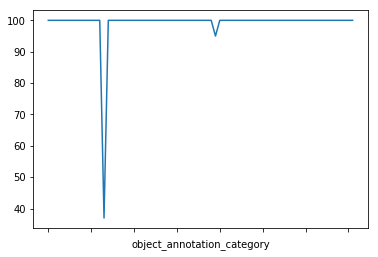

In [56]:
counts_per_class = preds_100_per_class_df.groupby('object_annotation_category')['object_id'].nunique()
counts_per_class.plot()

In [52]:
preds_100_per_class_df.to_csv('../ecotaxa_cnn_predictions_100_per_class_5150000_021120.csv', sep='\t')

In [51]:
dtps = []
for dt in prediction_subset.dtypes:
    if dt == 'float64':
        dtps.append('f')
    elif dt == 'object':
        dtps.append('t')
for f in dtps:
    print('['+f+']')

[t]
[t]
[t]
[t]
[f]
[f]
[t]
[f]


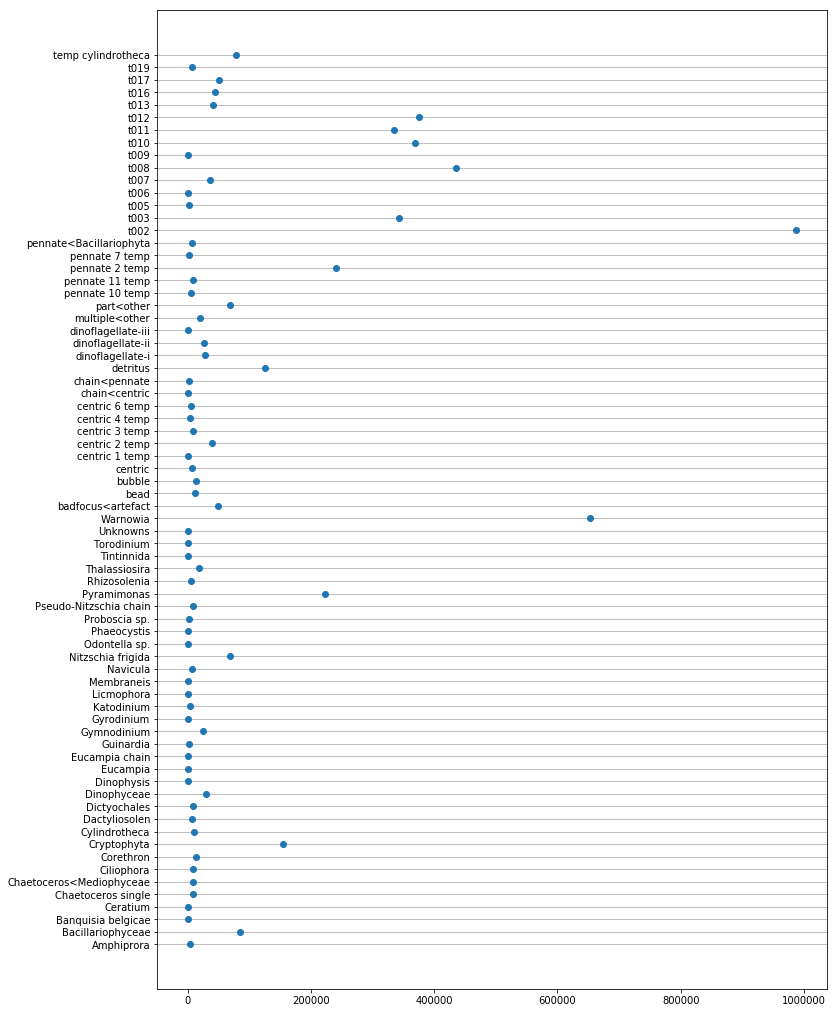

In [48]:
fig, ax = plt.subplots(figsize=(12, 18))
ax.scatter(counts, classes)
ax.set_yticks(classes)
ax.set_yticklabels([id_class_dict[x] for x in classes])
#ax.set_xlim(-10,500)
#ax.set_xscale('log')

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

# Turn on the minor TICKS, which are required for the minor GRID
#ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='grey', axis='y')
# Customize the minor grid
#ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
#plt.savefig('../output_predictions_131020.png', dpi=300)
plt.show()

In [146]:
min_count = 20
unique_validated = available_subset.groupby('object_annotation_category')['object_id'].nunique()

sufficient_classes = unique_validated[unique_validated >= min_count]

In [147]:
len(sufficient_classes)

73

In [46]:
#classes, counts = np.unique(labels, return_counts=True)
classes, counts

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 33, 34, 35, 36,
        37, 38, 39, 40, 41, 42, 44, 45, 46, 47, 48, 49, 50, 51, 52, 53, 54,
        55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70]),
 array([  26,  296,    1,    6,   58,   83,   39,   18,  935,   51,   14,
          28,  143,    1,    2,    1,    4,  169,   16,    9,    6,   21,
         492,    1,   15,    6,   65,  362,    5,   37,    1, 1671,  563,
          62,   85,   48,  142,   34,    3,   10,   19,  469,  140,  141,
           2,   44,   94,   52,   33,  877,   12,   16, 5581, 1519,    9,
           6,  244, 1566,    2, 1348,  874,  857,   22,   36,   25,   50,
         204]))

In [47]:
sufficient_classes

object_annotation_category
Amphiprora                     5339
Bacillariophyceae             28443
Banquisia belgicae               46
Ceratium                        224
Chaetoceros single             4805
Chaetoceros<Mediophyceae       1438
Ciliophora                     7245
Corethron                       919
Cryptophyta                   70779
Cylindrotheca                  3572
Dactyliosolen                   708
Dictyochales                  12322
Dinophyceae                   12792
Dinophysis                       48
Diplopsalis<Dinophyceae X        22
Eucampia                        279
Eucampia chain                   74
Guinardia                       518
Gymnodinium                   14367
Gyrodinium                      174
Katodinium                      838
Licmophora                      104
Membraneis                      322
Navicula                       1484
Nitzschia frigida             20343
Odontella sp.                    37
Phaeocystis                    2792
P

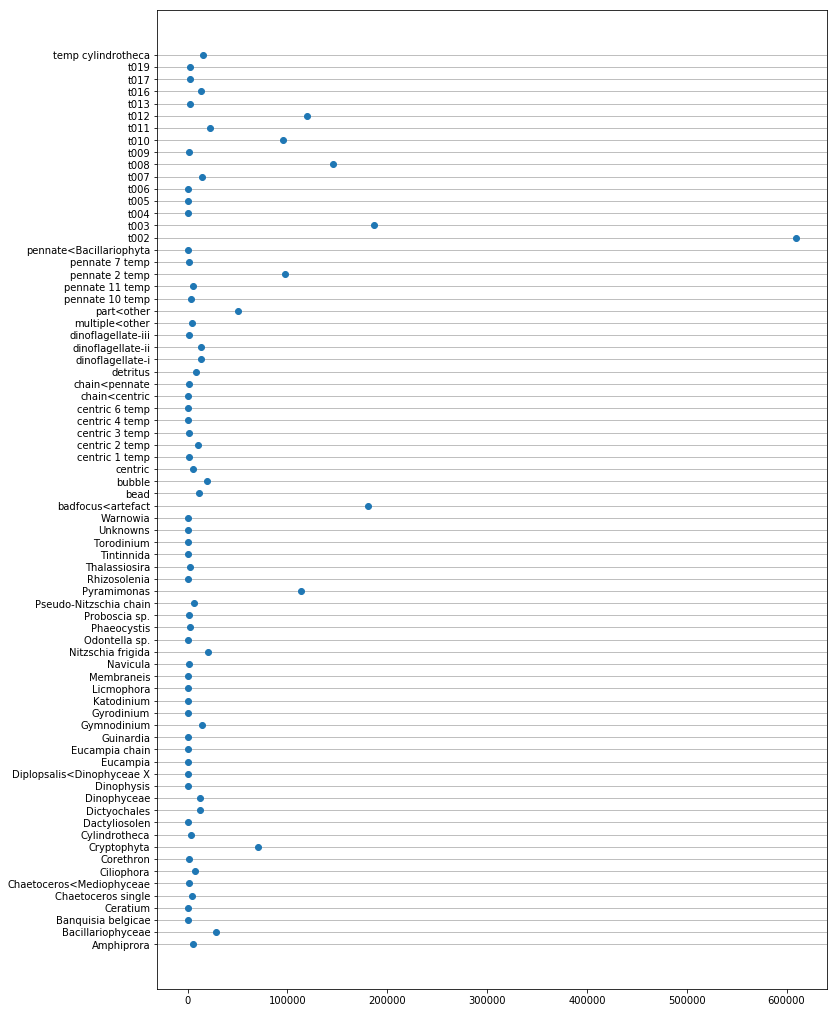

In [48]:
fig, ax = plt.subplots(figsize=(12, 18))
ax.scatter(sufficient_classes.values, range(0,len(sufficient_classes)))
ax.set_yticks(range(0,len(sufficient_classes)))
ax.set_yticklabels(list(sufficient_classes.index))
#ax.set_xlim(-10,500)
#ax.set_xscale('log')

# Don't allow the axis to be on top of your data
ax.set_axisbelow(True)

# Turn on the minor TICKS, which are required for the minor GRID
#ax.minorticks_on()

# Customize the major grid
ax.grid(which='major', linestyle='-', linewidth='0.5', color='grey', axis='y')
# Customize the minor grid
#ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

NameError: name 'sufficient_classes' is not defined

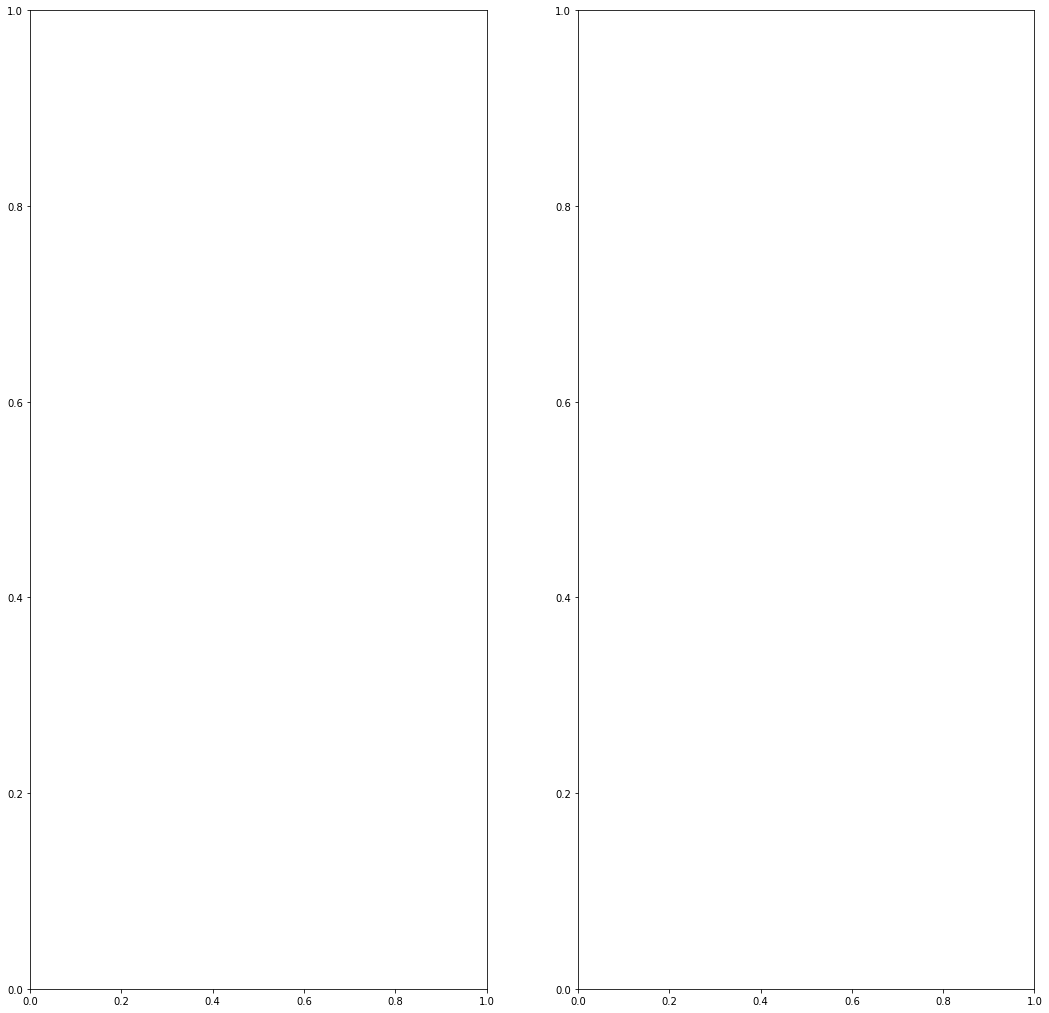

In [145]:
fig, ax = plt.subplots(1,2, figsize=(18, 18))
ax[1].scatter(sufficient_classes.values, range(0,len(sufficient_classes)))
ax[1].set_yticks(range(0,len(sufficient_classes)))
ax[1].set_yticklabels(list(sufficient_classes.index))
#ax.set_xlim(-10,500)
#ax.set_xscale('log')

# Don't allow the axis to be on top of your data
ax[1].set_axisbelow(True)
ax[1].set_xlim(-10,5000)
ax[1].set_title("Predictions")


# Turn on the minor TICKS, which are required for the minor GRID
#ax.minorticks_on()

# Customize the major grid
ax[1].grid(which='major', linestyle='-', linewidth='0.5', color='grey', axis='y')
# Customize the minor grid
#ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')

ax[0].scatter(counts, classes)
ax[0].set_yticks(range(0,len(class_id_dict)))
ax[0].set_yticklabels([id_class_dict[x] for x in classes])
ax[0].set_xlim(-10,2500)
#ax.set_xscale('log')

# Don't allow the axis to be on top of your data
ax[0].set_axisbelow(True)
ax[0].set_title("Validated Data")

# Turn on the minor TICKS, which are required for the minor GRID
#ax.minorticks_on()

# Customize the major grid
ax[0].grid(which='major', linestyle='-', linewidth='0.5', color='grey', axis='y')
# Customize the minor grid
#ax.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.savefig('output_predictions_comparison_full.png', dpi=300)
plt.show()

In [ ]:
# pull out only validated images and run it on them and see how close the total numbers compare